In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
import pandas as pd

import seaborn as sns

In [3]:
titanic = sns.load_dataset('titanic')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [4]:

results = pd.DataFrame(columns = ['Method','Dataset','Accuracy','Precision','Recall','F1'])

#결측치 모두 제거 
def drop_na(df):
    return df.dropna(subset=['age']) #컬럼을 지정할 수 있음

#평균으로 대치
def mean_imputation(df):
    df_filled = df.copy()
    df_filled['age'].fillna(df_filled['age'].mean(), inplace=True)
    return df_filled

#선형보간으로 
def linear_interpolation(df):
    df_filled = df.copy()
    df_filled['age'].interpolate(method='linear',inplace=True)
    return df_filled

#KNN으로 진행
def knn_imputation(df,n_neighbors =5):
    df_filled = df.copy()
    imputer=KNNImputer(n_neighbors = n_neighbors)
    df_filled[['age']]=imputer.fit_transform(df_filled[['age']])
    return df_filled


#다양한 방법으로 결측치를 보간하고 RF 모델에 학습시켜 train,test의 생존율 예측 결과를 확인하자!

# 각 방법을 적용하여 성능 테스트
methods = {
    'Drop NA': drop_na,
    'Mean Imputation':mean_imputation,
    'Linear Interpolation':linear_interpolation,
    'Knn Imputation' : knn_imputation
}

## 타이타닉 데이터로 반복을 돌려서 방법들을 다 하나씩 돌려서 성능 테스트를 넣어야 한다.
## 데이터를 학습시키기 위해서 train, test 로 나눠야 한다.
## 인코딩하는 get_dummies 인코딩 작업

for method_name, impute_func in methods.items():
    titanic_filled = impute_func(titanic)
    
    #학습할 데이터셋으로 나누기
    X = titanic_filled.drop(['survived','deck','alone','who','adult_male','alive','embark_town'],axis = 1)
    y = titanic_filled['survived']
    
    #원핫 인코딩으로 범주형 변수를 수치로 바꾸는 것
    X = pd.get_dummies(X, drop_first=True)    
    
    #데이터셋 분할
    X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=111)
    
    model = RandomForestClassifier(random_state=111)
    model.fit(X_train, y_train)
    
    # 성능에 대해서 평가한 것들을 데이터프레임 저장해야 한다.
    
    for dataset, X_data, y_data in (['Train',X_train, y_train],('Test',X_test, y_test)):
        y_pred = model.predict(X_data)
        
        #'Accuracy','Precision','Recall','F1'
        accuracy = accuracy_score(y_data, y_pred)
        precision = precision_score(y_data, y_pred)
        recall = recall_score(y_data, y_pred)
        f1 = f1_score(y_data, y_pred)        
        
        #결과 저장
        result_now=pd.DataFrame({
            'Method':[method_name],
            'Dataset':[dataset],
            'Accuracy':[accuracy],
            'Precision':[precision],
            'Recall':[recall],
            'F1':[f1]
        })
        results = pd.concat([results, result_now], ignore_index=True)
        
print(results)

                 Method Dataset  Accuracy  Precision    Recall        F1
0               Drop NA   Train  0.987741   0.991379  0.978723  0.985011
1               Drop NA    Test  0.776224   0.694915  0.745455  0.719298
2       Mean Imputation   Train  0.984551   0.985348  0.974638  0.979964
3       Mean Imputation    Test  0.826816   0.777778  0.742424  0.759690
4  Linear Interpolation   Train  0.988764   0.996296  0.974638  0.985348
5  Linear Interpolation    Test  0.832402   0.781250  0.757576  0.769231
6        Knn Imputation   Train  0.984551   0.985348  0.974638  0.979964
7        Knn Imputation    Test  0.826816   0.777778  0.742424  0.759690


## plt.subtitle('Method Com')   

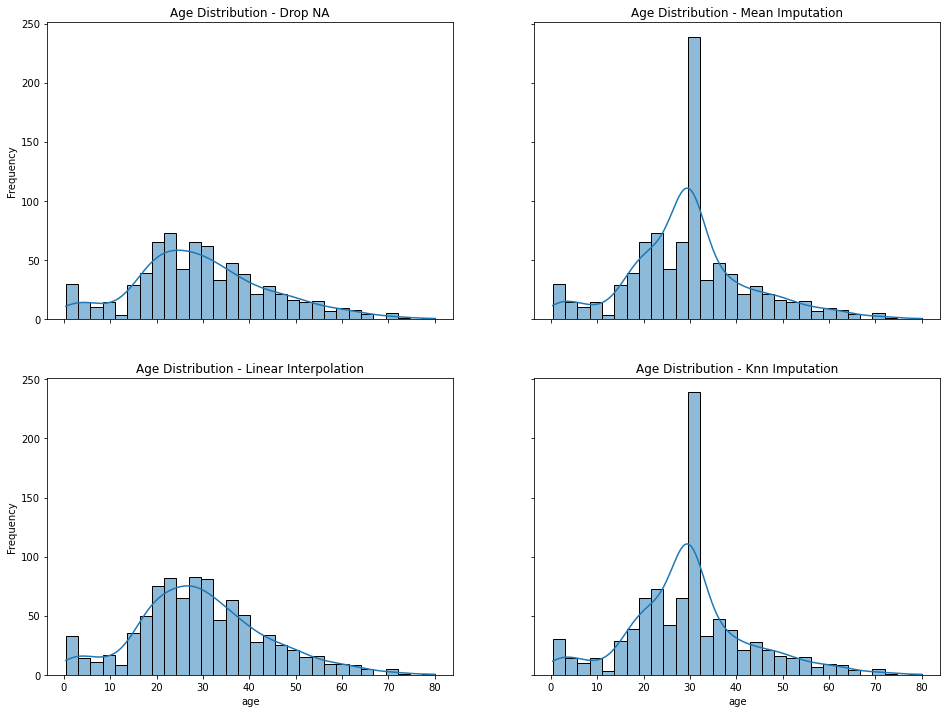

In [5]:
# 시각적으로 어떤 식으로 결측치가 보간 된 걸까?

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(16,12), sharex= True, sharey=True)
axes = axes.flatten() 

for ax,(method_name, impute_func) in zip (axes, methods.items()):
    titanic_filled = impute_func(titanic)
    
    # 분포를 살펴보기    
    sns.histplot(titanic_filled['age'], bins= 30, kde=True, ax=ax)
    ax.set_title(f'Age Distribution - {method_name}')
    ax.set_xlabel('age')
    ax.set_ylabel('Frequency')  

In [6]:
import numpy as np
# 예제용 타이타닉 데이터 로드
titanic = sns.load_dataset('titanic') 

# 요금 구간을 나누고 나이 결측치를 보간하는 함수 정의
def fill_age_based_on_rules(df):
    # 요금 구간(fare_bin)을 생성하여 결측치 보간 기준을 세분화
    df['fare_bin'] = pd.qcut(df['fare'], q=4, labels=['low', 'mid-low', 'mid-high', 'high'])

    # 성별, 승객 등급, 요금 구간별 평균 나이 계산
    age_means = df.groupby(['sex', 'pclass', 'fare_bin'])['age'].mean()

    # 결측치 보간 함수
    def fill_age(row):
        if np.isnan(row['age']):  # 나이가 결측치인 경우
            try:
                # 성별, 승객 등급, 요금 구간별 평균 나이를 대입
                return age_means[row['sex'], row['pclass'], row['fare_bin']]
            except KeyError:
                # 해당 그룹이 없을 경우 전체 평균으로 대체
                return df['age'].mean()
        return row['age']  # 결측치가 아닌 경우 원래 나이 반환

    # 각 행에 대해 결측치 보간 수행
    df['age'] = df.apply(fill_age, axis=1)
    df.drop(columns=['fare_bin'], inplace=True)  # 임시로 생성한 fare_bin 컬럼 제거
    return df

# 함수 적용
titanic = fill_age_based_on_rules(titanic)

# 결과 확인
print(titanic['age'].isnull().sum())  # 결측치가 없는지 확인

6


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 나이 결측치가 채워지지 않은 행 삭제
titanic_cleaned = titanic.dropna(subset=['age'])

# 독립변수와 종속변수 설정
X = titanic_cleaned.drop(['survived', 'deck', 'alone', 'who', 'adult_male', 'alive', 'embark_town'], axis=1)
y = titanic_cleaned['survived']

# 범주형 변수를 원-핫 인코딩
X = pd.get_dummies(X, drop_first=True)

# 학습 및 테스트 데이터셋으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# 랜덤 포레스트 모델 정의 및 훈련
model = RandomForestClassifier(random_state=111)
model.fit(X_train, y_train)

# 훈련 및 테스트 데이터에 대한 예측값 계산
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 성능 평가 (정확도, 정밀도, 재현율, F1 스코어)
metrics = {
    'Train': {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1 Score': f1_score(y_train, y_train_pred)
    },
    'Test': {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred)
    }
}

# 결과 출력
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


              Train      Test
Accuracy   0.981638  0.847458
Precision  0.988722  0.850000
Recall     0.963370  0.739130
F1 Score   0.975881  0.790698


### 이상치 데이터 
- 가상의 이상치 데이터를 만들어 보자!
- 제조공정의 데이터로 가정하고 만들어 보자!

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 시드 설정
np.random.seed(42)

# 데이터 생성
n_samples = 500
data = pd.DataFrame({
    'Temperature': np.random.normal(100, 5, n_samples),  # 평균 100°C, 표준편차 5
    'Pressure': np.random.normal(200, 10, n_samples),   # 평균 200kPa, 표준편차 10
    'Speed': np.random.normal(1500, 50, n_samples),     # 평균 1500rpm, 표준편차 50
    'DefectRate': np.random.normal(2, 0.5, n_samples)   # 평균 2%, 표준편차 0.5
})

# 이상치 추가
data.loc[10, 'Temperature'] = 200  # 온도 이상치
data.loc[20, 'Pressure'] = 300     # 압력 이상치
data.loc[30, 'Speed'] = 1000       # 속도 이상치
data.loc[40, 'DefectRate'] = 10    # 결함율 이상치

# 데이터 확인
print(data.head())

   Temperature    Pressure        Speed  DefectRate
0   102.483571  209.261775  1569.967772    2.389181
1    99.308678  219.094166  1546.231684    1.724407
2   103.238443  186.014324  1502.981518    1.590901
3   107.615149  205.629692  1467.653161    1.998313
4    98.829233  193.493574  1534.911166    1.914908


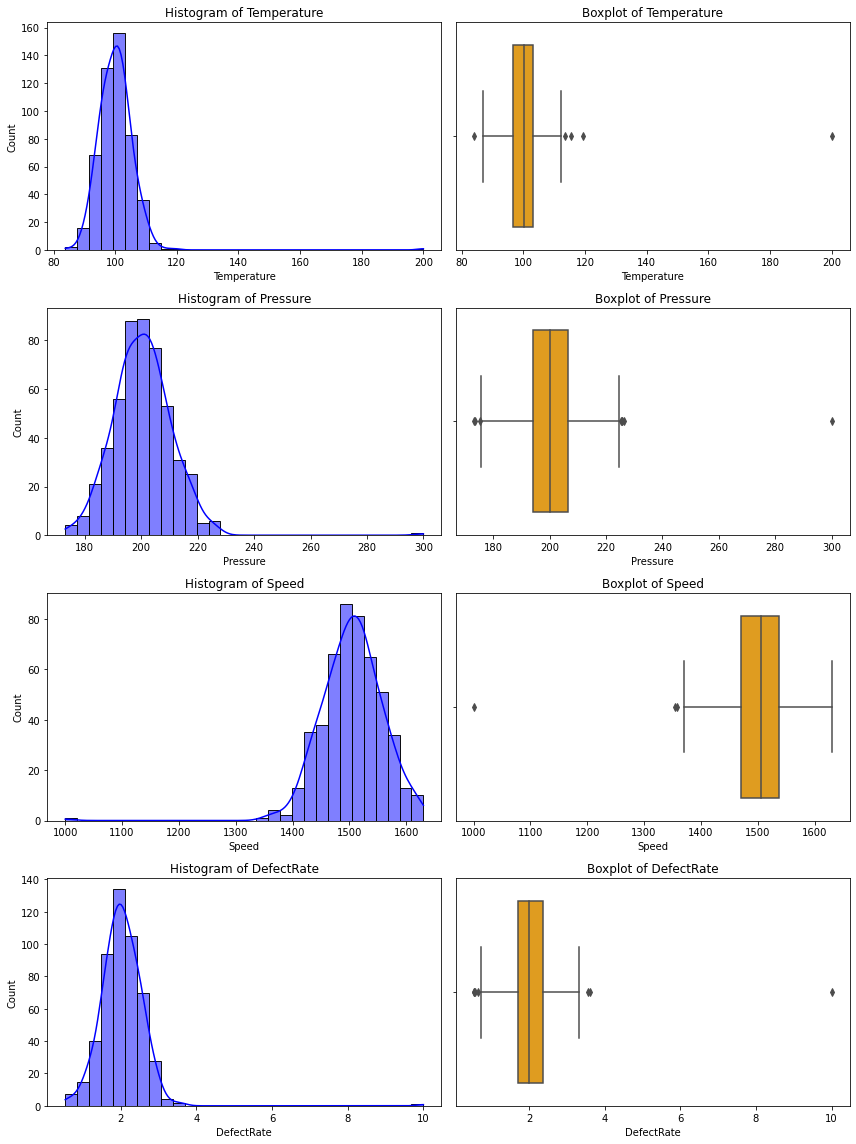

In [9]:
# 히스토그램 및 박스플롯 시각화
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for i, column in enumerate(data.columns):
    sns.histplot(data[column], bins=30, ax=axes[i, 0], kde=True, color='blue')
    axes[i, 0].set_title(f'Histogram of {column}')
    
    sns.boxplot(x=data[column], ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [11]:
def detect_outliers_iqr(df, column):
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers_iqr = {col: detect_outliers_iqr(data, col) for col in data.columns}
outliers_iqr

{'Temperature':      Temperature    Pressure        Speed  DefectRate
 10    200.000000  202.704568  1565.869703    1.429155
 179   113.600846  212.715551  1444.820534    1.784190
 209   119.263657  216.964564  1587.478837    1.512735
 262    83.793663  225.600845  1526.937800    2.037717
 478   115.394404  184.160972  1455.625391    1.613561,
 'Pressure':      Temperature    Pressure        Speed  DefectRate
 20    107.328244  300.000000  1526.141774    2.610517
 44     92.607390  175.283555  1491.368635    1.698894
 146    93.815246  173.031134  1445.186246    1.906428
 154   101.465362  225.733598  1582.100758    2.169242
 168    98.773059  173.490302  1529.737717    2.420310
 255    97.578830  226.323821  1439.517949    2.686829
 262    83.793663  225.600845  1526.937800    2.037717
 380    95.801391  225.269324  1533.896294    2.482426,
 'Speed':      Temperature    Pressure        Speed  DefectRate
 30     96.991467  206.385925  1000.000000    2.070443
 61     99.071705  220.7540

In [15]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
outlier_flags = iso.fit_predict(data)
outliers_iso = data[outlier_flags == -1]
outliser_iso

,Temperature,Pressure,Speed,DefectRate
10,200.000000,202.704568,1565.869703,1.429155
13,90.433599,190.924363,1465.540609,1.066732
20,107.328244,300.000000,1526.141774,2.610517
30,96.991467,206.385925,1000.000000,2.070443
31,109.261391,183.384799,1416.570796,1.115780
40,103.692333,208.356921,1584.196385,10.000000
44,92.607390,175.283555,1491.368635,1.698894
61,99.071705,220.754008,1357.572869,1.626394
97,101.305276,190.212363,1400.089966,3.028748
101,97.896773,190.778347,1355.187231,2.687438


In [16]:
def detect_outliers_rule_based(df):
    conditions = (
        (df['Temperature'] > 120) |
        (df['Pressure'] > 250) |
        (df['Speed'] < 1400) |
        (df['DefectRate'] > 5)
    )
    return df[conditions]

outliers_rule = detect_outliers_rule_based(data)
outliers_rule

,Temperature,Pressure,Speed,DefectRate
10,200.000000,202.704568,1565.869703,1.429155
20,107.328244,300.000000,1526.141774,2.610517
30,96.991467,206.385925,1000.000000,2.070443
40,103.692333,208.356921,1584.196385,10.000000
61,99.071705,220.754008,1357.572869,1.626394
101,97.896773,190.778347,1355.187231,2.687438
151,101.732241,211.265650,1392.330494,2.162898
160,95.126592,194.263380,1375.029714,2.658558
289,96.886502,183.390391,1392.355470,2.670225
346,92.759578,202.891686,1372.303943,2.632854


In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 데이터 정규화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 2. PCA 변환 (2차원으로 축소)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data['PCA1'] = data_pca[:, 0]
data['PCA2'] = data_pca[:, 1]

# 3. 각 기법으로 이상치 탐지 결과 추가
data['IQR_Outlier'] = 0
for col, outliers in outliers_iqr.items():
    data.loc[outliers.index, 'IQR_Outlier'] = 1

data['IsoForest_Outlier'] = 0
data.loc[outliers_iso.index, 'IsoForest_Outlier'] = 1

data['RuleBased_Outlier'] = 0
data.loc[outliers_rule.index, 'RuleBased_Outlier'] = 1


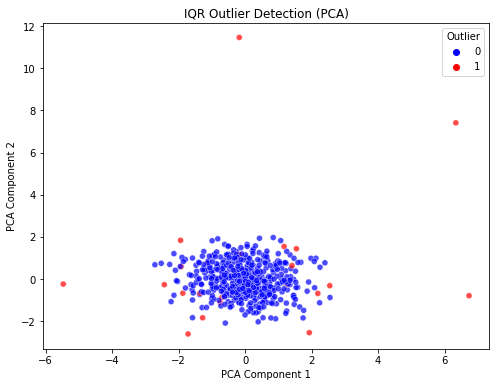

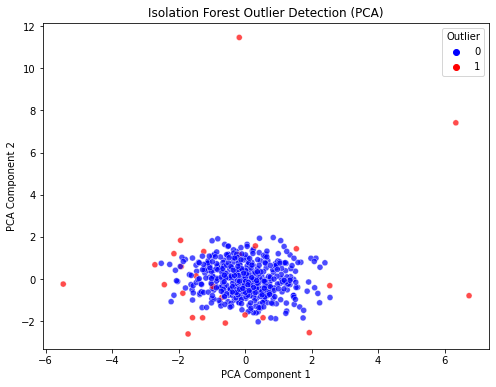

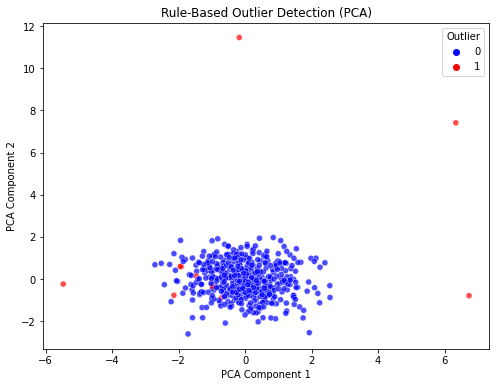

In [18]:
# 시각화 함수
def plot_outliers(data, method, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='PCA1', y='PCA2', data=data, 
        hue=method, palette={0: 'blue', 1: 'red'}, alpha=0.7
    )
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Outlier')
    plt.show()

# IQR 이상치 시각화
plot_outliers(data, 'IQR_Outlier', 'IQR Outlier Detection (PCA)')

# Isolation Forest 이상치 시각화
plot_outliers(data, 'IsoForest_Outlier', 'Isolation Forest Outlier Detection (PCA)')

# Rule-Based 이상치 시각화
plot_outliers(data, 'RuleBased_Outlier', 'Rule-Based Outlier Detection (PCA)')


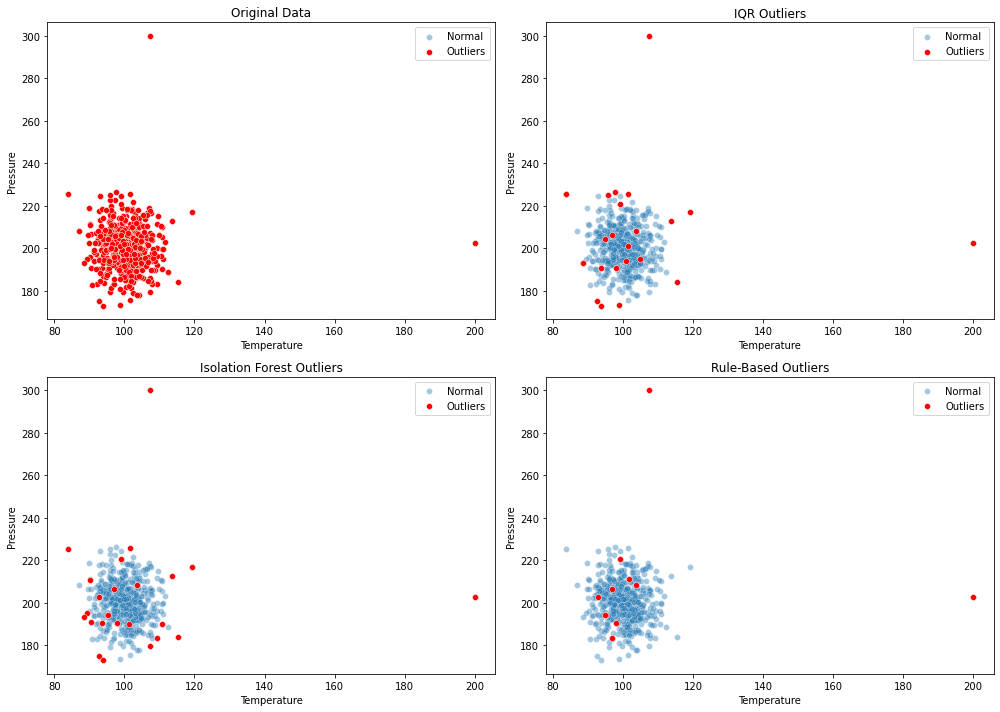

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods = {
    'Original Data': data,
    'IQR Outliers': pd.concat(outliers_iqr.values()),
    'Isolation Forest Outliers': outliers_iso,
    'Rule-Based Outliers': outliers_rule
}

for i, (method, df) in enumerate(methods.items()):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(x='Temperature', y='Pressure', data=data, ax=ax, label='Normal', alpha=0.4)
    sns.scatterplot(x='Temperature', y='Pressure', data=df, ax=ax, label='Outliers', color='red')
    ax.set_title(method)

plt.tight_layout()
plt.show()

# 전처리에 사용할 수 있는 다양한 함수
- apply
- pipe
- multi_index
- pivot_table
- transpose
- melt

### apply
- 데이터 프레임 전체 함수 적용시킬 때 많이 사용한 apply 문법

In [20]:
import seaborn as sns
import pandas as pd

df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [21]:
## 평균값으료 요금 전처리

df['fare'].mean()

32.2042079685746

In [22]:
## gruopby 와 함께 사용해서 함수를 적용시키는 것
## class fare에 대한 평균 값을 원한다.
df.groupby('class')['fare'].apply(lambda x: x.mean())

# apply(함수 처리 적용 가능)

class
First     84.154687
Second    20.662183
Third     13.675550
Name: fare, dtype: float64

In [23]:
## 함수를 만들어서 직접 바로 데이터프레임의 적용시키기

def cal_risk_score(row):
    age_score=row['age']/80
    pclass_score=(4-row['pclass'])/3
    return age_score + pclass_score

In [25]:
#apply로 간단하게 데이터 프레임에 적용
df['cal_risk_score'] = df.apply(cal_risk_score, axis=1)
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,cal_risk_score
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0.608333
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1.475000
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0.658333
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,1.437500
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0.770833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,1.004167
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,1.237500
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False,NaN
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True,1.325000


In [26]:
#다양한 함수를 통해 전처리 진행할 때 이런 식으로 pipe 만들어서 진행할 수 있다.

def convert_age_to_cateogry(df):
    df['AgeGroup']=pd.cut(df['age'], bins=[0,30,50,100], labels = ['Young','Middle-aged','Old'])
    return df

def normalize_fare(df):
    df['fare_normalize']=(df['fare']- df['fare'].mean()) / df['fare'].std()
    return df

def encode_gender(df):
    df['sex_encode'] = df['sex'].map({'male':0 , 'female':1})
    return df
                            
## 파이프라인
df_final=(
    df.pipe(convert_age_to_cateogry).pipe(normalize_fare).pipe(encode_gender)
)

df_final

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,cal_risk_score,AgeGroup,fare_normalize,sex_encode
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0.608333,Young,-0.502163,0
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1.475000,Middle-aged,0.786404,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0.658333,Young,-0.488580,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,1.437500,Middle-aged,0.420494,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0.770833,Middle-aged,-0.486064,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,1.004167,Young,-0.386454,0
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,1.237500,Young,-0.044356,1
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False,NaN,NaN,-0.176164,1
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True,1.325000,Young,-0.044356,0


### multi_index
- 다중인덱스
- 인덱스가 1개가 아니라 2개 이상인 경우

In [27]:
df_sp=df[['survived','sex','class','embarked','fare']]

In [28]:
## group by 형태로 들어가서 묶어서 데이터를 요약하여 보고 싶다!
## set_index() - 인덱스를 재지정
## reset_index() - 인덱스를 초기화

multi_idx=df_sp.set_index(['class','sex','embarked']).groupby(level=[0,1,2]).mean()

In [29]:
## 멀티인덱스를 접근하기 위해서는 다른 문법으로 진행해야 한다.
multi_idx

survived        fare
class  sex    embarked                      
First  female C         0.976744  115.640309
              Q         1.000000   90.000000
              S         0.958333   99.026910
       male   C         0.404762   93.536707
              Q         0.000000   90.000000
              S         0.354430   52.949947
Second female C         1.000000   25.268457
              Q         1.000000   12.350000
              S         0.910448   21.912687
       male   C         0.200000   25.421250
              Q         0.000000   12.350000
              S         0.154639   19.232474
Third  female C         0.652174   14.694926
              Q         0.727273   10.307833
              S         0.375000   18.670077
       male   C         0.232558    9.352237
              Q         0.076923   11.924251
              S         0.128302   13.307149

In [30]:
multi_idx.loc[('First','female')]

,survived,fare
embarked,,
C,0.976744,115.640309
Q,1.000000,90.000000
S,0.958333,99.026910


In [31]:
multi_idx.loc[('First')]

survived        fare
sex    embarked                      
female C         0.976744  115.640309
       Q         1.000000   90.000000
       S         0.958333   99.026910
male   C         0.404762   93.536707
       Q         0.000000   90.000000
       S         0.354430   52.949947

In [32]:
multi_idx

survived        fare
class  sex    embarked                      
First  female C         0.976744  115.640309
              Q         1.000000   90.000000
              S         0.958333   99.026910
       male   C         0.404762   93.536707
              Q         0.000000   90.000000
              S         0.354430   52.949947
Second female C         1.000000   25.268457
              Q         1.000000   12.350000
              S         0.910448   21.912687
       male   C         0.200000   25.421250
              Q         0.000000   12.350000
              S         0.154639   19.232474
Third  female C         0.652174   14.694926
              Q         0.727273   10.307833
              S         0.375000   18.670077
       male   C         0.232558    9.352237
              Q         0.076923   11.924251
              S         0.128302   13.307149

In [33]:
#멀티 인덱스도 슬라이싱 가능

multi_idx.loc['First':'Second']

survived        fare
class  sex    embarked                      
First  female C         0.976744  115.640309
              Q         1.000000   90.000000
              S         0.958333   99.026910
       male   C         0.404762   93.536707
              Q         0.000000   90.000000
              S         0.354430   52.949947
Second female C         1.000000   25.268457
              Q         1.000000   12.350000
              S         0.910448   21.912687
       male   C         0.200000   25.421250
              Q         0.000000   12.350000
              S         0.154639   19.232474

In [34]:
multi_idx.loc['Second':'Third']

survived       fare
class  sex    embarked                     
Second female C         1.000000  25.268457
              Q         1.000000  12.350000
              S         0.910448  21.912687
       male   C         0.200000  25.421250
              Q         0.000000  12.350000
              S         0.154639  19.232474
Third  female C         0.652174  14.694926
              Q         0.727273  10.307833
              S         0.375000  18.670077
       male   C         0.232558   9.352237
              Q         0.076923  11.924251
              S         0.128302  13.307149

In [35]:
## xs 메서드를 이용해서 내가 원하는 인덱스 값을 적고, 해당 인덱스 값의 인덱스를 적어주면서 추출을 다양하게 진행할 수 있다.

multi_idx.xs('female', level='sex')

survived        fare
class  embarked                      
First  C         0.976744  115.640309
       Q         1.000000   90.000000
       S         0.958333   99.026910
Second C         1.000000   25.268457
       Q         1.000000   12.350000
       S         0.910448   21.912687
Third  C         0.652174   14.694926
       Q         0.727273   10.307833
       S         0.375000   18.670077

In [36]:
multi_idx.xs('male', level='sex')

survived       fare
class  embarked                     
First  C         0.404762  93.536707
       Q         0.000000  90.000000
       S         0.354430  52.949947
Second C         0.200000  25.421250
       Q         0.000000  12.350000
       S         0.154639  19.232474
Third  C         0.232558   9.352237
       Q         0.076923  11.924251
       S         0.128302  13.307149

#### pivot_table
    - 행과 열에 대해서 재구조화 하는 형태
- values -값
- index - 행
- columns - 열
- aggfunc - 집계함수
- 위의 조절하는 하이퍼파라미터 개념의 인자를 통해서 여러 개 조절해서 데이터를 피벗할 수 있다.

In [38]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,cal_risk_score,AgeGroup,fare_normalize,sex_encode
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0.608333,Young,-0.502163,0
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1.475000,Middle-aged,0.786404,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0.658333,Young,-0.488580,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,1.437500,Middle-aged,0.420494,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0.770833,Middle-aged,-0.486064,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,1.004167,Young,-0.386454,0
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,1.237500,Young,-0.044356,1
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False,NaN,NaN,-0.176164,1
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True,1.325000,Young,-0.044356,0


In [39]:
df.pivot_table(values='survived',index='sex',columns='pclass',aggfunc='sum')

pclass,1,2,3
sex,,,
female,91,70,72
male,45,17,47


In [40]:
df.pivot_table(values='survived',index='sex',columns='pclass',aggfunc='count')

pclass,1,2,3
sex,,,
female,94,76,144
male,122,108,347


In [41]:
df.pivot_table(values='who',index='sex',columns='pclass',aggfunc='sum')

pclass,1,2,3
sex,,,
female,womanwomanwomanwomanwomanwomanwomanwomanwomanw...,childwomanwomanchildwomanwomanchildwomanwomanw...,womanwomanchildchildwomanwomanchildchildwomanw...
male,manmanmanmanmanmanmanmanmanmanmanmanmanmanmanm...,manmanmanmanmanmanchildmanmanmanmanmanmanmanma...,manmanmanchildmanmanchildmanmanmanmanmanmanman...


In [42]:
df.pivot_table(values='who',index='sex',columns='pclass',aggfunc='count')

pclass,1,2,3
sex,,,
female,94,76,144
male,122,108,347


In [43]:
df.pivot_table(values='survived',index='sex',columns='pclass',aggfunc=['count','sum']) # 확장의 경우는 기존의 배운 groupby 동일하게 적용

count           sum        
pclass     1    2    3   1   2   3
sex                               
female    94   76  144  91  70  72
male     122  108  347  45  17  47

In [44]:
## 반전
## transpose() 축반전
## 행과 열 전체를 반전시키는 것
df.transpose()
#df.T 같은 의미

,0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
survived,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
pclass,3,1,3,1,3,3,1,3,3,2,...,3,3,2,3,3,2,1,3,1,3
sex,male,female,female,female,male,male,male,male,female,female,...,male,female,male,male,female,male,female,female,male,male
age,22.0,38.0,26.0,35.0,35.0,NaN,54.0,2.0,27.0,14.0,...,33.0,22.0,28.0,25.0,39.0,27.0,19.0,NaN,26.0,32.0
sibsp,1,1,0,1,0,0,0,3,0,1,...,0,0,0,0,0,0,0,1,0,0
parch,0,0,0,0,0,0,0,1,2,0,...,0,0,0,0,5,0,0,2,0,0
fare,7.25,71.2833,7.925,53.1,8.05,8.4583,51.8625,21.075,11.1333,30.0708,...,7.8958,10.5167,10.5,7.05,29.125,13.0,30.0,23.45,30.0,7.75
embarked,S,C,S,S,S,Q,S,S,S,C,...,S,S,S,S,Q,S,S,S,C,Q
class,Third,First,Third,First,Third,Third,First,Third,Third,Second,...,Third,Third,Second,Third,Third,Second,First,Third,First,Third
who,man,woman,woman,woman,man,man,man,child,woman,child,...,man,woman,man,man,woman,man,woman,woman,man,man


### melt 함수
- 데이터를 깔끔하게 정리할 때 사용한다
- 여기서 깔끔함이란 것은? 

----
- id_vars : 그대로 유지할 값
- values_vars : 되돌리기 할 열을 나타내는 것 id_vars로 지정하지 않은 다른 모든 열들을 피벗 되어 되돌린다.
- var_name : values_vars 되돌린 값이 새로운 컬럼이 생기면 이름 지정할 때 사용, 디폴트는 variable
- value_name : var_name의 열의 값을 나타내는 새로운 열의 이름 문자

In [65]:
pew=pd.read_csv('C:/Users/user/BDA_Data/Dataset/pew.csv')

In [66]:
pd.melt(pew,id_vars='religion', var_name='income', value_name='count')

,religion,income,count
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15
...,...,...,...
175,Orthodox,Don't know/refused,73
176,Other Christian,Don't know/refused,18
177,Other Faiths,Don't know/refused,71
178,Other World Religions,Don't know/refused,8


In [62]:
bb=pd.read_csv('C:/Users/user/BDA_Data/Dataset/billboard.csv')

In [63]:
pd.melt(bb, id_vars=['year','artist','track','time','date.entered'])

,year,artist,track,time,date.entered,variable,value
0,2000,2 Pac,Baby Don't Cry (Keep...,4:22,2000-02-26,wk1,87.0
1,2000,2Ge+her,The Hardest Part Of ...,3:15,2000-09-02,wk1,91.0
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,wk1,81.0
3,2000,3 Doors Down,Loser,4:24,2000-10-21,wk1,76.0
4,2000,504 Boyz,Wobble Wobble,3:35,2000-04-15,wk1,57.0
...,...,...,...,...,...,...,...
24087,2000,Yankee Grey,Another Nine Minutes,3:10,2000-04-29,wk76,NaN
24088,2000,"Yearwood, Trisha",Real Live Woman,3:55,2000-04-01,wk76,NaN
24089,2000,Ying Yang Twins,Whistle While You Tw...,4:19,2000-03-18,wk76,NaN
24090,2000,Zombie Nation,Kernkraft 400,3:30,2000-09-02,wk76,NaN


In [64]:
bb

,year,artist,track,time,date.entered,wk1,wk2,wk3,wk4,wk5,...,wk67,wk68,wk69,wk70,wk71,wk72,wk73,wk74,wk75,wk76
0,2000,2 Pac,Baby Don't Cry (Keep...,4:22,2000-02-26,87,82.0,72.0,77.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2Ge+her,The Hardest Part Of ...,3:15,2000-09-02,91,87.0,92.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,3 Doors Down,Kryptonite,3:53,2000-04-08,81,70.0,68.0,67.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,3 Doors Down,Loser,4:24,2000-10-21,76,76.0,72.0,69.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,504 Boyz,Wobble Wobble,3:35,2000-04-15,57,34.0,25.0,17.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,2000,Yankee Grey,Another Nine Minutes,3:10,2000-04-29,86,83.0,77.0,74.0,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,2000,"Yearwood, Trisha",Real Live Woman,3:55,2000-04-01,85,83.0,83.0,82.0,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,2000,Ying Yang Twins,Whistle While You Tw...,4:19,2000-03-18,95,94.0,91.0,85.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,2000,Zombie Nation,Kernkraft 400,3:30,2000-09-02,99,99.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
ebola=pd.read_csv('C:/Users/user/BDA_Data/Dataset/country_timeseries.csv')

In [58]:
ebola_melt= pd.melt(ebola, id_vars=['Date','Day'])

In [59]:
# split 을 이용해서 값을 _ 기준으로 두 개 나눠서 새로운 변수에 담는다
ebola_melt['case']=ebola_melt.variable.str.split('_').str.get(0)

In [60]:
# split 을 이용해서 값을 _ 기준으로 두 개 나눠서 새로운 변수에 담는다
ebola_melt['country']=ebola_melt.variable.str.split('_').str.get(1)

In [61]:
ebola_melt

,Date,Day,variable,value,case,country
0,1/5/2015,289,Cases_Guinea,2776.0,Cases,Guinea
1,1/4/2015,288,Cases_Guinea,2775.0,Cases,Guinea
2,1/3/2015,287,Cases_Guinea,2769.0,Cases,Guinea
3,1/2/2015,286,Cases_Guinea,NaN,Cases,Guinea
4,12/31/2014,284,Cases_Guinea,2730.0,Cases,Guinea
...,...,...,...,...,...,...
1947,3/27/2014,5,Deaths_Mali,NaN,Deaths,Mali
1948,3/26/2014,4,Deaths_Mali,NaN,Deaths,Mali
1949,3/25/2014,3,Deaths_Mali,NaN,Deaths,Mali
1950,3/24/2014,2,Deaths_Mali,NaN,Deaths,Mali
